Overlay function (Foreground on image)

Sparse Map (Phase 4)
        ↓
Initial Labels (Phase 5)
        ↓
Pseudo-label Refinement (Phase 6)
        ↓
Self-evolution (Phase 7)
        ↓
Feedback to Sparse Optimization
        ↓
Updated Sparse Map 
        ↓
Final Detection


In [11]:
def overlay_foreground(frame_gray, fg_mask):

    frame_rgb = np.stack([frame_gray]*3, axis=-1)
    overlay = frame_rgb.copy()
    overlay[fg_mask == 1] = [255, 0, 0]
    return overlay


In [12]:
def preprocess_frame(img, target_size=(256, 256)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, target_size)
    return gray


In [13]:
def load_image_sequence(images, img_dir, num_frames=5):
    seq = []

    for img_info in images[:num_frames]:
        img_path = os.path.join(img_dir, img_info["file_name"])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = preprocess_frame(img)
        seq.append(img)

    return seq


In [14]:
def estimate_background(frames):
   
    stack = np.stack(frames, axis=0)
    background = np.mean(stack, axis=0)
    return background


In [15]:
def extract_foreground(frame, background, thresh=25):
 
    diff = np.abs(frame.astype(np.float32) - background)
    fg = (diff > thresh).astype(np.uint8)
    return fg


In [16]:
def phase4_sparse_optimization(frames, thresh=25):
    """
    HiEUM Phase 4: Sparse motion map generation
    """
    background, fg_masks = hieum_detect(frames, thresh)

    fg_stack = np.stack(fg_masks, axis=0)  # T x H x W
    S = np.mean(fg_stack, axis=0)           # H x W

    return S


In [17]:
def hieum_detect(frames, thresh=25):
    background = estimate_background(frames)

    fg_masks = []
    for frame in frames:
        fg = extract_foreground(frame, background, thresh)
        fg_masks.append(fg)

    return background, fg_masks



In [18]:
import json
import os
DATA_ROOT = "C:/Users/KimiaMalekizadeh/Downloads/VISO/coco/car"
IMG_DIR = os.path.join(DATA_ROOT, "train2017")
ANN_PATH = os.path.join(DATA_ROOT, "Annotations", "instances_train2017_small.json")

with open(ANN_PATH, "r") as f:
    coco = json.load(f)

images = coco["images"]

print("Images loaded:", len(images))


Images loaded: 50


In [19]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

frames = load_image_sequence(images, IMG_DIR, num_frames=10)
for i, f in enumerate(frames):
    print(f"Frame {i} shape:", f.shape)

background, fg_masks = hieum_detect(frames, thresh=20)


Frame 0 shape: (256, 256)
Frame 1 shape: (256, 256)
Frame 2 shape: (256, 256)
Frame 3 shape: (256, 256)
Frame 4 shape: (256, 256)
Frame 5 shape: (256, 256)
Frame 6 shape: (256, 256)
Frame 7 shape: (256, 256)
Frame 8 shape: (256, 256)
Frame 9 shape: (256, 256)


Display the final results

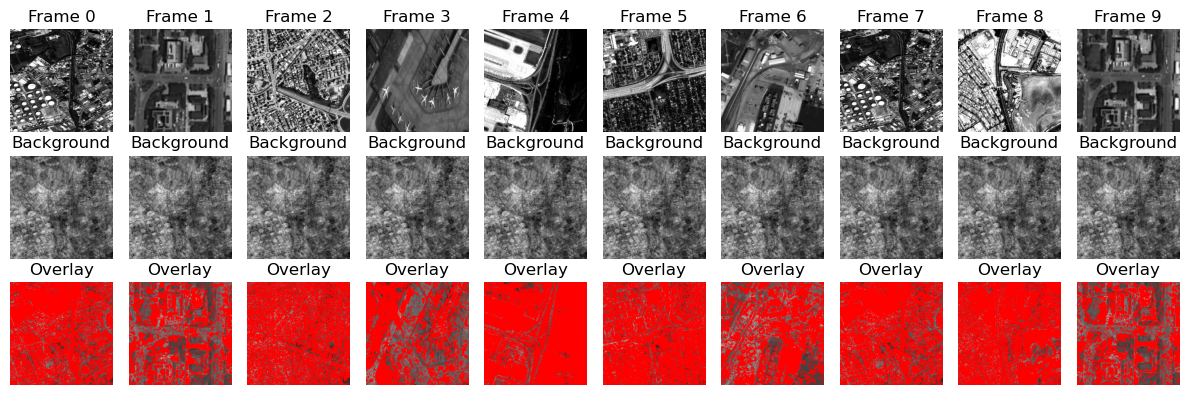

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))


background, fg_masks = hieum_detect(frames, thresh=20)

for i in range(len(frames)):
    plt.subplot(3, len(frames), i+1)
    plt.imshow(frames[i], cmap="gray")
    plt.axis("off")
    plt.title(f"Frame {i}")

    plt.subplot(3, len(frames), i+1+len(frames))
    plt.imshow(background, cmap="gray")
    plt.axis("off")
    plt.title("Background")

    plt.subplot(3, len(frames), i+1+2*len(frames))
    overlay = overlay_foreground(frames[i], fg_masks[i])
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Overlay")

plt.tight_layout()
plt.show()


In [21]:
if __name__ == "__main__":
    frames = load_image_sequence(images, IMG_DIR, num_frames=10)
    background, fg_masks = hieum_detect(frames)
